In [1]:
from __future__ import print_function

import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
from tensorflow.keras import backend as K
assert len(keras.backend.tensorflow_backend._get_available_gpus()) > 0

# Train the ANNs

In [7]:
costs = pd.read_csv("~/code/fifteen-puzzle/data/datasets/15-costs-v1.csv", nrows=6000000)
costs.shape

(6000000, 17)

In [8]:
costs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cost
0,13,4,7,15,8,0,2,1,9,6,10,14,3,12,5,11,56
1,10,2,4,12,3,13,8,0,1,5,6,7,14,9,11,15,34
2,8,15,11,14,13,5,6,7,4,9,12,0,1,2,10,3,59
3,1,0,10,6,2,3,14,8,9,7,4,13,5,11,12,15,43
4,1,5,6,8,3,4,9,14,11,10,2,12,13,15,0,7,41


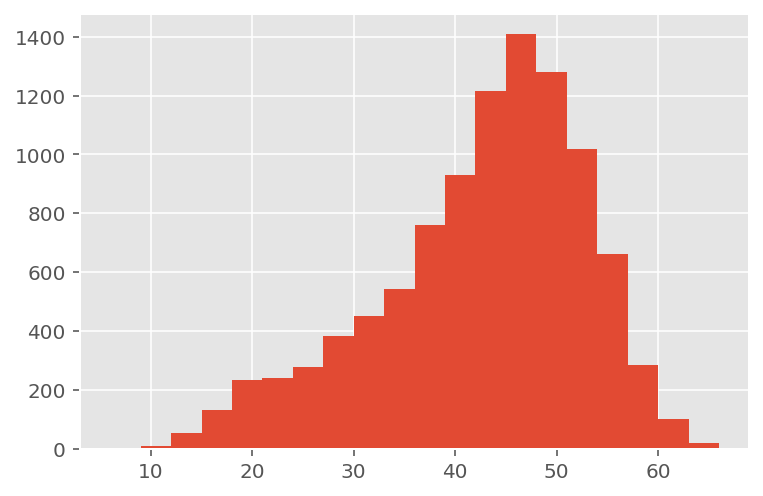

In [9]:
costs.sample(10000).cost.hist(bins=20);

In [10]:
X_raw = costs.iloc[:,:-1].values
y = costs['cost'].values

In [11]:
X = np.apply_along_axis(lambda x: np.eye(16)[x].ravel(), 1, X_raw)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42) 

In [13]:
del X, y

In [14]:
def get_model(layer_sizes, 
              learning_rate=0.001, 
              dropout_ratio=0.2, 
              activation='elu', 
              loss='mean_squared_error',
              kernel_initializer='he_normal', 
              batch_normalize=True,
              kernel_regularizer=None):
    model = Sequential()
    model.add(Dense(layer_sizes[0], 
                    input_shape=(256,), 
                    activation=activation, 
                    kernel_initializer=kernel_initializer,
                    kernel_regularizer=kernel_regularizer))
    model.add(Activation(activation))
    if batch_normalize:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_ratio))
    
    for layer_size in layer_sizes[1:]:
        model.add(Dense(layer_size, 
                        activation=activation, 
                        kernel_initializer=kernel_initializer,
                        kernel_regularizer=kernel_regularizer))
        model.add(Activation(activation))
        if batch_normalize:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_ratio))

    model.add(Dense(1, kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer))
    model.compile(loss=loss,
                  optimizer=Adam(lr=learning_rate))
    return model

## MSE

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=0, restore_best_weights=True)

model = get_model([1024, 512, 256, 128, 64], 
                  learning_rate=0.03, 
                  dropout_ratio=0.2)

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 4800000 samples, validate on 1200000 samples
Epoch 1/10
4800000/4800000 [==============================] - 193s 40us/sample - loss: 9.7216 - val_loss: 3.1760
Epoch 2/10
4800000/4800000 [==============================] - 192s 40us/sample - loss: 4.8794 - val_loss: 4.2345
Epoch 3/10
4800000/4800000 [==============================] - 184s 38us/sample - loss: 4.4896 - val_loss: 3.1944
Epoch 4/10
4800000/4800000 [==============================] - 183s 38us/sample - loss: 4.2605 - val_loss: 2.5573
Epoch 5/10
4800000/4800000 [==============================] - 186s 39us/sample - loss: 4.1475 - val_loss: 2.4930
Epoch 6/10
4800000/4800000 [==============================] - 184s 38us/sample - loss: 4.1058 - val_loss: 1775329820716.9966
Epoch 7/10
4800000/4800000 [==============================] - 180s 38us/sample - loss: 4.0127 - val_loss: 2.2877
Epoch 8/10
4800000/4800000 [==============================] - 

In [17]:
model.save('keras-1024-512-256-128-64-mse.h5')

## AMSE, alpha=0.2

In [19]:
def asymmetric_mean_squared_error_02(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true) * K.square(K.sign(y_pred - y_true) + 0.2), axis=-1)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=0, restore_best_weights=True)

model = get_model([1024, 512, 256, 128, 64], 
                  learning_rate=0.03, 
                  dropout_ratio=0.2,
                  loss=asymmetric_mean_squared_error_02)

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

Train on 4800000 samples, validate on 1200000 samples
Epoch 1/10
4800000/4800000 [==============================] - 179s 37us/sample - loss: 8.5331 - val_loss: 3.2246
Epoch 2/10
4800000/4800000 [==============================] - 178s 37us/sample - loss: 4.6951 - val_loss: 3.2886
Epoch 3/10
4800000/4800000 [==============================] - 202s 42us/sample - loss: 4.3548 - val_loss: 2.4503
Epoch 4/10
4800000/4800000 [==============================] - 204s 43us/sample - loss: 4.1416 - val_loss: 3.4673
Epoch 5/10
4800000/4800000 [==============================] - 216s 45us/sample - loss: 4.0423 - val_loss: 2.5528
Epoch 6/10
4800000/4800000 [==============================] - 204s 43us/sample - loss: 3.9312 - val_loss: 38.1496


In [21]:
model.save('keras-1024-512-256-128-64-amse02.h5')

## AMSE, alpha=0.4

In [22]:
def asymmetric_mean_squared_error_04(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true) * K.square(K.sign(y_pred - y_true) + 0.4), axis=-1)

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=0, restore_best_weights=True)

model = get_model([1024, 512, 256, 128, 64], 
                  learning_rate=0.03, 
                  dropout_ratio=0.2,
                  loss=asymmetric_mean_squared_error_04)

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

Train on 4800000 samples, validate on 1200000 samples
Epoch 1/10
4800000/4800000 [==============================] - 234s 49us/sample - loss: 6.7202 - val_loss: 2.9400
Epoch 2/10
4800000/4800000 [==============================] - 228s 48us/sample - loss: 3.9112 - val_loss: 2.7155
Epoch 3/10
4800000/4800000 [==============================] - 221s 46us/sample - loss: 3.5837 - val_loss: 2.3651
Epoch 4/10
4800000/4800000 [==============================] - 223s 46us/sample - loss: 3.4553 - val_loss: 2.2600
Epoch 5/10
4800000/4800000 [==============================] - 227s 47us/sample - loss: 3.3634 - val_loss: 6.1963
Epoch 6/10
4800000/4800000 [==============================] - 224s 47us/sample - loss: 3.2891 - val_loss: 429.3320
Epoch 7/10
4800000/4800000 [==============================] - 219s 46us/sample - loss: 3.2355 - val_loss: 2.6182


In [24]:
model.save('keras-1024-512-256-128-64-amse04.h5')

## AMSE, alpha=0.6

In [25]:
def asymmetric_mean_squared_error_06(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true) * K.square(K.sign(y_pred - y_true) + 0.6), axis=-1)

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=0, restore_best_weights=True)

model = get_model([1024, 512, 256, 128, 64], 
                  learning_rate=0.03, 
                  dropout_ratio=0.2,
                  loss=asymmetric_mean_squared_error_06)

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

Train on 4800000 samples, validate on 1200000 samples
Epoch 1/10
4800000/4800000 [==============================] - 221s 46us/sample - loss: 4.3265 - val_loss: 1.8190
Epoch 2/10
4800000/4800000 [==============================] - 229s 48us/sample - loss: 2.7546 - val_loss: 1.7206
Epoch 3/10
4800000/4800000 [==============================] - 228s 48us/sample - loss: 2.6166 - val_loss: 159.9440
Epoch 4/10
4800000/4800000 [==============================] - 229s 48us/sample - loss: 2.4897 - val_loss: 26044.3119
Epoch 5/10
4800000/4800000 [==============================] - 196s 41us/sample - loss: 2.3860 - val_loss: 199.0945


In [27]:
model.save('keras-1024-512-256-128-64-amse06.h5')